# Temporal Precipitation Interpolation Dataset

## Task

Given precipitation maps $M_{i}$ and $M_{i+s}$ at time $t_{i}$ and $t_{i+s}$ .

Estimate $M_{i + 1} .. M_{i + s - 1} $

For the validation purpose, we use Meteonet dataset, which offers 5 min temporal resolution.


## Meteonet

Meteonet dataset is available at: https://meteonet.umr-cnrm.fr/dataset/

```
   CHANGELOG.md
   LICENCE.md
 + data/
     + NW/
         ..
     + SE/
         ..
         + radar/
             + rainfall/
                 SE_rainfall_2016.tar.gz
                 SE_rainfall_2017.tar.gz
                 SE_rainfall_2018.tar.gz
```

The coordinates information for the radar observation is available at: https://github.com/meteofrance/meteonet/tree/master/data_samples/radar
as radar_coords_NW.npz and radar_coords_SE.npz.

Our PyTorch Dataset assumes the following directory structure under ./dataset/meteonet as follows:

```
   radar_coords_NW.npz
   ..
 + SE_rainfall_2018/
     ..
     rainfall-SE-2018-12.tar.gz (original downloaded, ~300MB)
     + rainfall-SE-2018-12/
         rainfall_SE_2018_12.1.npz (original extracted, ~100MB)
         rainfall_SE_2018_12.2.npz
         rainfall_SE_2018_12.3.npz
```

The following scripts should do it for you.

```
$ cd dataset
$ mkdir meteonet
$ ./download_radar_coords.sh
$ ./download_radar.sh
```

## Note in visualization

ToTensor converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0] if the PIL Image belongs to one of the modes (L, LA, P, I, F, RGB, YCbCr, RGBA, CMYK, 1) or if the numpy.ndarray has dtype = np.uint8.

Meteonet numpy.ndarray (H x W) should be reshaped to (C x H x W).

In [1]:
from importlib import reload

import precipitation
reload(precipitation)
from precipitation.dataset import MeteonetRadarRainfall

from IPython.display import Code
display(Code(filename='precipitation/dataset.py'))

import datetime
import glob
import os.path
import numpy as np
import torch.utils.data as data


class MeteonetRadarRainfall(data.Dataset):
    """
    A dataloader for loading N samples arranged in this way:
        
        extracted from Meteonet .pth files (glob path should )
        |-- dataset/meteonet
            |-- SE_rainfall_2016
            |-- SE_rainfall_2017
            |-- SE_rainfall_2018
                |-- rainfall-SE-2018-01
                    rainfall_SE_2018_01.1.npz 1/3 month of 
                    rainfall_SE_2018_01.2.npz
                    rainfall_SE_2018_01.3.npz
                |-- rainfall-SE-2018-02
                :
                |-- rainfall-SE-2018-12
    ...

    Attributes
    ----------
    root : string
        the root dataset directory
    pathnames : list
        List of path (glob patterns) used in in the dataset directory.

    Methods
    -------
    __getitem__(index)
        Returns the sample corresponding to `index` from dataset.
    __len__()
        Returns the size of dataset. Invoked as len(datasetObj).
    __repr__()
        Returns printable representation of the dataset object.
    """


    def __init__(self, *args, root= "./dataset/meteonet",
                 fname_coords="radar_coords_SE.npz",
                 pathnames=["SE_rainfall_2018/rainfall-SE-2018-01/*.npz"],
                 dim=(784, 515), randomCropSize=(352, 352),
                 random_seed=None, skip_frames=12,
                 train=True, transform=None, download=False, **kwargs):
        """
        Parameters
        ----------
            root : string
                Root directory path.
            transform : callable, optional
                A function/transform that takes in
                a sample and returns a transformed version.
                E.g, ``transforms.RandomCrop`` for images.
            dim : tuple, optional
                Dimensions of images in dataset in width x height. Default: (784, 515)
            randomCropSize : tuple, optional
                Dimensions of random crop to be applied. Default: (352, 352)
            train : boolean, optional
                Specifies if the dataset is for training or testing/validation.
                `True` returns samples with data augmentation like random 
                flipping, random cropping, etc. while `False` returns the
                samples without randomization.
                In training, half-hourly consecutive 9 frames (out of 12 frames) are selected,
                while frames for every 5 min in testing.
                Default: True
        """
        
        #if not transform:
        #    transform = transforms.Compose([
        #        transforms.ToTensor(),
        #        transforms.Normalize((0.5), (0.5))
        #    ])
        #self.transform = transform
        #super(MeteonetRadarRainfall, self).__init__(*args, transform=transform, **kwargs)
        
        self.train = train
        self.rng = np.random.default_rng(random_seed)
        
        coords = np.load(os.path.join(root, fname_coords), allow_pickle=True)
        #it is about coordinates of the center of pixels
        self.lon = coords['lons']
        self.lat = coords['lats']
        
        self.randomCropSize = randomCropSize
        self.cropX0         = dim[0] - randomCropSize[0]
        self.cropY0         = dim[1] - randomCropSize[1]
        self.root           = root
        self.transform      = transform
        self.train          = train
        
        self.data_dict = {}
        self.dates_dict = {}
        self.miss_dates_dict = {}
        
        clips = []
        
        res = 6 if train else 1 # 30 min for training, 5min for evaluation
        input_frames = 3 if train else 7 # 30min x 3 / 5min x 7
        
        #index = 0
        for glob_pathname in pathnames:
            fnames = glob.glob(os.path.join(root, glob_pathname))
            
            for fname in fnames:
                d = np.load(fname, a

## Test

In [2]:
import torch
from superslomo.model import backWarp

TRAIN_BATCH_SIZE = 6
VALIDATION_BATCH_SIZE = 10

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
trainFlowBackWarp      = backWarp(352, 352, device).to(device)
validationFlowBackWarp = backWarp(640, 352, device).to(device)

In [3]:
import numpy as np
import torch
import torchvision.transforms as transforms


# Channel wise mean calculated on adobe240-fps training dataset
mean = [0.429, 0.431, 0.397]
std  = [1, 1, 1]
normalize = transforms.Normalize(mean=mean,
                                 std=std)
#transform = transforms.Compose([transforms.ToTensor(), normalize])

def to_tensor(frame):
    return torch.cat([torch.from_numpy(frame.reshape(1, *frame.shape)),
                      torch.zeros(2, *frame.shape)],
                     dim=0)
    
transform = transforms.Compose([
    to_tensor,
])

trainset = MeteonetRadarRainfall(root='./dataset/meteonet',
                                 pathnames=["SE_rainfall_2018/rainfall-SE-2018-01/*.[1].npz"],
                                 transform=transform, train=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)

validationset = MeteonetRadarRainfall(root='./dataset/meteonet',
                                      pathnames=["SE_rainfall_2018/rainfall-SE-2018-01/*.3.npz"],
                                      transform=transform, randomCropSize=(640, 352), train=False)
validationloader = torch.utils.data.DataLoader(validationset, batch_size=VALIDATION_BATCH_SIZE, shuffle=False)

print(trainset, validationset)

Dataset MeteonetRadarRainfall
    Number of datapoints: 160
    Root Location: ./dataset/meteonet
    Transforms (if any): Compose(
                             <function to_tensor at 0x7f39f5681f70>
                         )
 Dataset MeteonetRadarRainfall
    Number of datapoints: 527
    Root Location: ./dataset/meteonet
    Transforms (if any): Compose(
                             <function to_tensor at 0x7f39f5681f70>
                         )



In [4]:
# (ch, h, w) = (h, w)
to_z = lambda ch_h_w: ch_h_w[0].reshape(*ch_h_w.shape[1:]).numpy()

Intermediate frame index:  tensor(3)
torch.Size([6, 3, 515, 784])
torch.Size([515, 784])


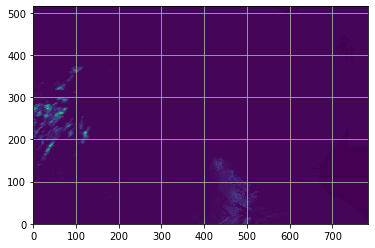

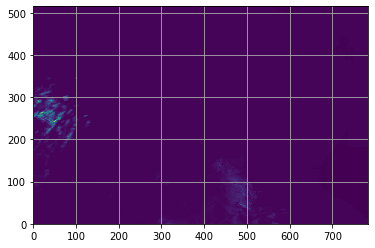

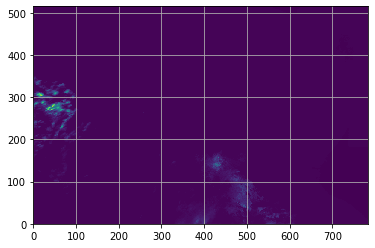

In [5]:
import matplotlib.pyplot as plt


for trainIndex, (trainData, frameIndex) in enumerate(trainloader, 0):
    frame0, frameT, frame1 = trainData
    print("Intermediate frame index: ", (frameIndex[0]))
    print(frame0.shape)
    print(frame0[0][0].shape)
    plt.pcolormesh(to_z(frame0[0]))
    plt.grid(True)
    plt.figure()
    plt.pcolormesh(to_z(frameT[0]))
    plt.grid(True)
    plt.figure()
    plt.pcolormesh(to_z(frame1[0]))
    plt.grid(True)
    break